In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
import sys
print(sys.version)
print(spark.version)

3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
3.1.3


In [2]:
from google.cloud import storage

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
# from pyspark.sql import functions as F
from pyspark.sql.types import *

# Create spark_session
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
bucket_write = 'msca-bdp-students-bucket/shared_data_shuklakm'

gs_read_twitter_filt_path = 'gs://' + bucket_write + '/twitter_data/part-*.parquet'

gs_read_user_selected_data_filt_path = 'gs://' + bucket_write + '/user_selected_data_filt/part-*.parquet'
gs_read_retweeted_status_text_filt_path = 'gs://' + bucket_write + '/retweeted_status_text_filt/part-*.parquet'
gs_read_quoted_status_text_path = 'gs://' + bucket_write + '/quoted_status_text/part-*.parquet'


In [7]:
retweet_data = spark.read.parquet(gs_read_retweeted_status_text_filt_path, header='true', inferSchema='true')

In [8]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [14]:
retweet_df = retweet_data.withColumn("quoted_status_id", retweet_data["quoted_status_id"].cast(IntegerType())).\
withColumn("retweeted_quote_count", retweet_data["retweeted_quote_count"].cast(IntegerType())).\
withColumn("retweet_count", retweet_data["retweet_count"].cast(IntegerType())).\
withColumn("id", retweet_data["id"].cast(IntegerType())).\
withColumn("reply_count", retweet_data["reply_count"].cast(IntegerType())).\
withColumn("statuses_count", retweet_data["statuses_count"].cast(IntegerType()))

In [15]:
tweet_df = retweet_df.withColumnRenamed("City","city").\
withColumnRenamed("retweeted_text", "text")
tweet_df.limit(5).toPandas()

,quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count
0,1557626880,IE,Wicklow,Tue Jun 28 09:09:21 +0000 2022,0,1,"<a href=""http://twitter.com/download/android"" rel=""nofollow"">Twitter for Android</a>",0,False,@johnsweeneyroar Books. Mosul university. 2018.\n\nYou instantly reminded me of this. It's a terrible sight..\n\nhttps://t.co/l5juqDnHmX,irishelt,-1597844104,Irish Emergency Logistics Team: Professional Logisticians - Delivering Dignity Worldwide,87642
1,1528238081,US,Knoxville,Sun Sep 11 20:50:08 +0000 2022,1,30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,VoteGloriaJ,358432869,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",155293
2,1591033856,US,St Louis,Mon Jul 18 19:59:45 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,"schools need to be early on my guy @evan_simon3 … lives in the gym, always studying film &amp; looking for ways to impr… https://t.co/Av6bFxlFBd",CoachJBAH,-1365819391,@ArsenalHoops @BHS_STL @BrandPatient,571
3,777261056,GB,Barnsley,Mon Jul 18 18:05:11 +0000 2022,0,1,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,I love my job in fundraising but visiting schools is the best part ⭐️ 👏🏻 #youngfundraisers #communitysupport,VickyStead,45215231,"Full time wife & mum to my 3 beautiful boys, part time Fundraiser & Health Care Assistant at Barnsley Hospice. Always burning the candle at both ends YOLO!",1086
4,1276801026,US,Atlanta,Mon Sep 19 15:07:06 +0000 2022,2002,4823,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",804,False,I’m perfectly fine standing on this hill by myself. But wanting HBCU culture at white schools… instead of going to… https://t.co/HNGxWgV8Wq,BigHomieKODAQ,47252785,"Exec Prod: @bigfactspod • @thebeatatl 7pm-12am M- Thu • Hoodrich-@bighomieshouse• #CAU grad 📧:Kodaq@BigFactsPod.com Ft in: Shaderoom, Essence, ESPN ,RevoltTV",596482


In [16]:
extract_description = tweet_df.\
withColumn("title", tweet_df.description.substr(0,15))

extract_description_df = extract_description
extract_description_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
1557626880,IE,Wicklow,Tue Jun 28 09:09:...,0,1,"<a href=""http://t...",0,false,@johnsweeneyroar ...,irishelt,-1597844104,Irish Emergency L...,87642,Irish Emergency
1528238081,US,Knoxville,Sun Sep 11 20:50:...,1,30,"<a href=""http://t...",1,false,This is one of th...,VoteGloriaJ,358432869,State Rep. TN HD1...,155293,State Rep. TN H
1591033856,US,St Louis,Mon Jul 18 19:59:...,0,1,"<a href=""http://t...",0,false,schools need to b...,CoachJBAH,-1365819391,@ArsenalHoops @BH...,571,@ArsenalHoops @
777261056,GB,Barnsley,Mon Jul 18 18:05:...,0,1,"<a href=""http://t...",0,false,I love my job in ...,VickyStead,45215231,Full time wife & ...,1086,Full time wife
1276801026,US,Atlanta,Mon Sep 19 15:07:...,2002,4823,"<a href=""http://t...",804,false,I’m perfectly fin...,BigHomieKODAQ,47252785,Exec Prod: @bigfa...,596482,Exec Prod: @big


In [12]:
government_df = extract_description_df.filter((col("description").contains("government")) |
                                   (col("description").contains("State Represent")) |
                                   (col("description").contains("State Rep")) |
                                    (col("description").contains("President")) |
                                    (col("description").contains("Democratic")) |
                                    (col("description").contains("Political science")) 
                                             )
government_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
1528238081,US,Knoxville,Sun Sep 11 20:50:...,1,30,"<a href=""http://t...",1,false,This is one of th...,VoteGloriaJ,358432869,State Rep. TN HD1...,155293,State Rep. TN H
-1047117823,GB,Edinburgh,Wed Sep 07 07:28:...,2,28,"<a href=""http://t...",0,false,All power to the ...,janetfarrarUCU,-766058494,She/her; UCU Pres...,1330,She/her; UCU Pr
-342384639,US,Knoxville,Mon May 23 18:15:...,0,9,"<a href=""http://t...",0,false,Look at the free ...,VoteGloriaJ,358432869,State Representat...,150980,State Represent
1679454208,IN,Chandigarh,Mon Sep 19 15:47:...,0,6,"<a href=""http://t...",0,false,Punjab education ...,brinderdhillon,137433560,"President, Punjab...",4847,"President, Punj"
1653977088,US,Knoxville,Tue Sep 27 23:44:...,0,24,"<a href=""http://t...",3,false,The best entrance...,GrantFrerking,1539792192,@Vol_Football #0 ...,5151,@Vol_Football #


In [17]:
health_df = extract_description_df.filter((col("description").contains("health")) |
                                   (col("description").contains("doctor")) |
                                   (col("description").contains("nurse")))
health_df.limit(2).toPandas()

,quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
0,1528238081,US,Knoxville,Sun Sep 11 20:50:08 +0000 2022,1,30,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1,False,This is one of the many reasons using public tax dollars to fund schools with less or no transparency is a disaster… https://t.co/na1RnVzrE0,VoteGloriaJ,358432869,"State Rep. TN HD13 (HD90 in 2022). Retired special ed teacher, OFA Alum, healthcare advocate, public school supporter, she/her, #blm. Always standing TALL!",155293,State Rep. TN H
1,-426094587,US,St Paul,Fri Oct 07 18:47:09 +0000 2022,1,5,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",0,False,This graph right here! 👇\nDeclining state investment in our public schools has led to huge revenue gaps. An over-rel… https://t.co/YdHYWjct4P,DeniseSpecht,27655477,Licensed MN elementary teacher. #Union. @EducationMN president. @AFTunion VP. Blocking the bullies and trolls for the health of it.,19818,Licensed MN ele


In [18]:
### Assessing the similarity on TEXT variables

In [19]:
health_df.limit(5)

quoted_status_id,country_code,name,retweeted_created_at,retweeted_quote_count,retweet_count,source,reply_count,retweeted,text,screen_name,id,description,statuses_count,title
1528238081,US,Knoxville,Sun Sep 11 20:50:...,1,30,"<a href=""http://t...",1,false,This is one of th...,VoteGloriaJ,358432869,State Rep. TN HD1...,155293,State Rep. TN H
-426094587,US,St Paul,Fri Oct 07 18:47:...,1,5,"<a href=""http://t...",0,false,This graph right ...,DeniseSpecht,27655477,Licensed MN eleme...,19818,Licensed MN ele
-1047117823,GB,Edinburgh,Wed Sep 07 07:28:...,2,28,"<a href=""http://t...",0,false,All power to the ...,janetfarrarUCU,-766058494,She/her; UCU Pres...,1330,She/her; UCU Pr
-342384639,US,Knoxville,Mon May 23 18:15:...,0,9,"<a href=""http://t...",0,false,Look at the free ...,VoteGloriaJ,358432869,State Representat...,150980,State Represent
-1621676023,US,Parma Heights,Sun Apr 10 21:40:...,18,206,"<a href=""http://t...",106,false,If you’re going t...,mirandayaver,1704646470,Political science...,100627,Political scien


In [20]:
df_text_raw = health_df.select(["text"])
df_text_raw.limit(5)

text
This is one of th...
This graph right ...
All power to the ...
Look at the free ...
If you’re going t...


In [21]:
text = df_text_raw.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")


tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 3] )\
    .map( lambda word: [x for x in word if x not in StopWords])\
    .zipWithIndex()

In [22]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
df_text.limit(5)

text,id
{This is one of t...,0
{This graph right...,1
{All power to the...,2
{Look at the free...,3
{If you’re going ...,4


In [23]:
df_text.count()

969

In [24]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
df_tokens.limit(5).toPandas()

,list_of_words,id
0,"[many, reasons, using, public, dollars, fund, schools, less, transparency, disaster…, https://t.co/na1rnvzre0]",0
1,"[graph, right, here!, 👇\ndeclining, state, investment, public, schools, huge, revenue, gaps., over-rel…, https://t.co/ydhywjct4p]",1
2,"[power, @nw_ucu, @ucu, colleges, strike, today, support, amazing, across, union, https://t.co/l6qbtkns5s]",2
3,"[look, free, fall, young, people, signing, college, @govbilllee., disaster, education,, https://t.co/5oxvfkwszs]",3
4,"[you’re, going, graduating, one’s, class,, graduating, college, all,, maybe, act…, https://t.co/2orqb426p0]",4


In [25]:
df_tokens.printSchema()

root
 |-- list_of_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)



In [26]:
# Fit countvectorizer to create word features
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)


In [27]:
df_vectorize.limit(5).toPandas()


,list_of_words,id,features
0,"[many, reasons, using, public, dollars, fund, schools, less, transparency, disaster…, https://t.co/na1rnvzre0]",0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
1,"[graph, right, here!, 👇\ndeclining, state, investment, public, schools, huge, revenue, gaps., over-rel…, https://t.co/ydhywjct4p]",1,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
2,"[power, @nw_ucu, @ucu, colleges, strike, today, support, amazing, across, union, https://t.co/l6qbtkns5s]",2,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...)"
3,"[look, free, fall, young, people, signing, college, @govbilllee., disaster, education,, https://t.co/5oxvfkwszs]",3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"
4,"[you’re, going, graduating, one’s, class,, graduating, college, all,, maybe, act…, https://t.co/2orqb426p0]",4,"(2.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...)"


In [28]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize)

In [29]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left')
df_hashed_text.limit(5)

id,text,list_of_words,features,hashes
65,{If you’re going ...,"[you’re, going, g...","(935,[0,1,3,4,5,6...","[[4.7945584E7], [..."
54,{This is an impor...,"[important, threa...","(935,[2,11,24,37,...","[[1.75609176E8], ..."
77,{This piece about...,"[piece, importanc...","(935,[11,24,70,11...","[[1.60975862E8], ..."
50,{Today marks the ...,"[today, marks, fi...","(935,[12,16,65,12...","[[1.9024249E8], [..."
57,{They've been doi...,"[they've, decades...","(935,[12,14,117,2...","[[7.1157861E7], [..."


In [30]:
jaccard_distance = 0.3

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [31]:
df_dups_30 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,8,95,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
1,0.0,41,107,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
2,0.0,65,96,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
3,0.0,39,104,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
4,0.0,86,88,"(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)","(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)"


In [32]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  969
Duplicate texts based on { 0.3 } jaccard distance:  842
Unique texts based on { 0.3 } jaccard distance:  0.3 :  127


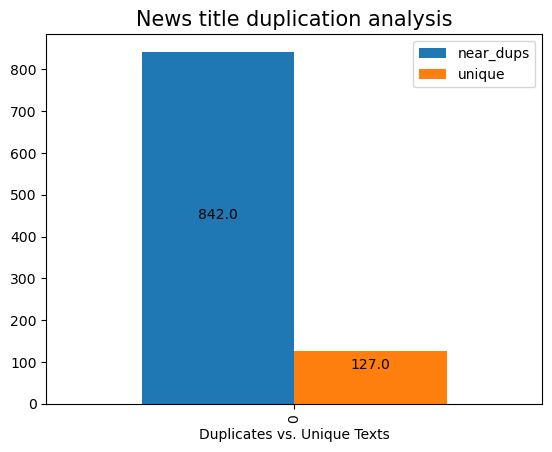

In [33]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Texts")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

<AxesSubplot:ylabel='Frequency'>

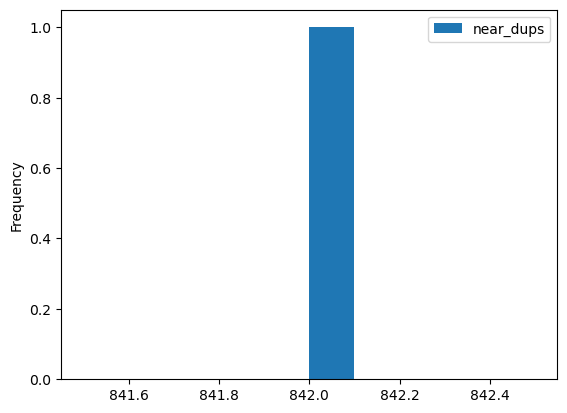

In [34]:
dups_df.plot(kind = 'hist',y='near_dups', fontsize=10, xlabel="Overall distribution of “near-duplication of 30%")


In [35]:
jaccard_distance = 0.5

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [36]:
df_dups_50 = df_dups_text
df_dups_text.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,8,95,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
1,0.0,41,107,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
2,0.0,65,96,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
3,0.0,39,104,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
4,0.0,86,88,"(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)","(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)"


In [37]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  969
Duplicate texts based on { 0.5 } jaccard distance:  842
Unique texts based on { 0.5 } jaccard distance:  0.5 :  127


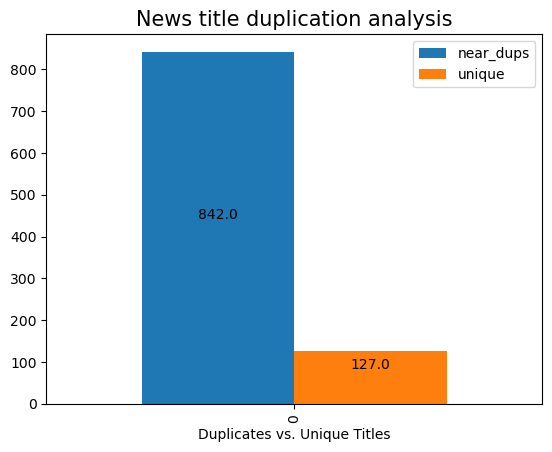

In [38]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Titles")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 

In [39]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B'),
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            ) 

In [40]:
df_dups_70 = df_dups_text
df_dups_70.limit(5).toPandas()

,distCol,id_A,id_B,text_A,text_B
0,0.0,862,883,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
1,0.0,868,879,"(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)","(If you’re going to lie about graduating in the top 1% of one’s class, or graduating from college at all, maybe act… https://t.co/2ORqB426p0,)"
2,0.0,66,842,"(Yet 18 year old high school or college kids are too young to hear “divisive concepts” in school or they aren’t read… https://t.co/vzwWqa5XFP,)","(Yet 18 year old high school or college kids are too young to hear “divisive concepts” in school or they aren’t read… https://t.co/vzwWqa5XFP,)"
3,0.0,70,687,"(Hey @MeidasTouch @meiselasb our Gov has been trying to get 50-100 @Hillsdale charter schools here, this is one of t… https://t.co/mPmoPmkUua,)","(Hey @MeidasTouch @meiselasb our Gov has been trying to get 50-100 @Hillsdale charter schools here, this is one of t… https://t.co/mPmoPmkUua,)"
4,0.0,53,742,"(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)","(This is an important thread on the destruction planned for our public schools by Moms for Liberty. They are startin… https://t.co/wU4wbB086M,)"


In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate texts based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique texts based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique Titles")
ax.set_title('News title duplication analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 